# Set up

In [333]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla

import time

In [334]:
# 设置全局的字体大小和加粗 ### plt.rcParams
plt.rc('figure', figsize = [7,7])
plt.rc('font', size=20, weight='bold', family = 'Arial')  # 全局字体大小和加粗
plt.rc('axes', titlesize=20, titleweight='bold', titlepad = 15,
        labelpad=10, labelsize=18, labelweight='bold', linewidth = 1.2)  # 坐标轴标题和标签的字体
plt.rc('lines', linewidth = 2.2)
plt.rc('legend', framealpha = 0, loc = 'best')

plt.rc('xtick', labelsize=18, direction = 'in', top = True)  # x轴刻度标签字体大小
plt.rc('ytick', labelsize=18, direction = 'in', right = True)  # y轴刻度标签字体大小
plt.rc('xtick.major', size = 4, width = 2, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.major', size = 4, width = 2, pad = 4)  # y轴刻度线宽度
plt.rc('xtick.minor', size = 2, width = 0.8, pad = 4)  # x轴刻度线宽度
plt.rc('ytick.minor', size = 2, width = 0.8, pad = 4)  # y轴刻度线宽度

## Structure

In [335]:
class DeviceStates:
    def __init__(
            self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        ### Define default parameters
        self.default_material_params = {

            'epsilon_FE': 24,  # FE background permittivity 
            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity
            'epsilon_Spacer': 6.3, # Spacer dielectric permittivity 
            'epsilon_Insulator': 1, # insulator dielectric permittivity 

            'N_donor': 1e17 *1e6,  # Drain Donor Doping concentration in m^-3
            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'mu_n': 0.14,  # electron mobility in m^2/V/s
            'mu_p': 0.041,  # hole mobility in m^2/V/s

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1e6,

            'E_g': 1.12,  # silicon bandgap in eV
            'E_d': -0.046,  # donor energy level under conduction band
            'E_a': 0.044,  # acceptor energy level under valence band
        }

        self.default_device_params = {

            'dz': 0.2e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m
            'Gate_length': 100e-9,  # MOSFET gate length in m
            'FE_thickness': 5e-9,  # FE thickness in m
            'DE_thickness': 1e-9,  # DE thickness in m
            'Si_thickness': 10e-9,  # Silicon channel thickness in m
            'Spacer_length': 25e-9, # spacer length in m
            'Insulator_Under_Si_thickness': 5e-9, # insulator under silicon thickness in m
            'Gate_drain_overlap_length': 4e-9, # gate / drain overlap length in m

        }

        self.default_electrical_params = {

            'V_Gate': 0,  # Gate Voltage
            'V_Drain': 0,  # Drain Voltage
            'V_Source': 0,  # Source Voltage
            'V_Substrate': 0,  # Substrate Voltage 
            'Is_Ground_Substrate': True, 

        }

        self.default_physics_params = {

            'epsilon_0': 8.854e-12,
            'k_B': 1.38e-23, 
            'T_0': 300, 
            'e_charge': 1.6e-19,
            'Use_Boltzmann_distribution': True, 
            'Use_Complete_ionization': True,

        }

        self.default_math_params = {
            'Gummel_Max_iter': 10, # Gummel Map maximum number of iterations
            'Gummel_tolerance': 1e-6, # Gummel Map tollerance
            'Poisson_Solver': 'Jacobi', 

            'Poisson_Jacobi_solver_tolerance': 1e-6,
            'Poisson_Jacobi_solver_max_step': 30000, 
            'Poisson_Jacobi_solver_omega_V': 1,

            'Poisson_Sparse_Matrix_max_update': 0.1, 

        }

        ### Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        ### initialize the device params and device physics variables and physics functions
        self.initialize_device_params()
        self.initialize_device_states()
        self.initialize_device_functions()

    def initialize_device_params(self):
        ###### Physics constant Parameters
        self.epsilon_0 = self.default_physics_params['epsilon_0']
        self.k_B = self.default_physics_params['k_B']
        self.T_0 = self.default_physics_params['T_0']
        self.e_charge = self.default_physics_params['e_charge']
        self.V_thermal = self.k_B * self.T_0 / self.e_charge
        self.Use_Boltzmann_distribution = self.default_physics_params['Use_Boltzmann_distribution']
        self.Use_Complete_ionization = self.default_physics_params['Use_Complete_ionization']

        # ### debug
        # self.Boltzmann = self.default_physics_params['Use_Boltzmann_distribution']

        ###### Device Material Parameters
        self.epsilon_FE = self.default_material_params['epsilon_FE']  # FE background permittivity 
        self.epsilon_IL = self.default_material_params['epsilon_IL']  # Interfacial Layer Dielectric permittivity 
        self.epsilon_Si = self.default_material_params['epsilon_Si']  # Silicon permittivity 
        self.epsilon_Spacer = self.default_material_params['epsilon_Spacer']  # Spacer dielectric permittivity 
        self.epsilon_Insulator = self.default_material_params['epsilon_Insulator']  # Spacer dielectric permittivity 
        
        self.N_donor = self.default_material_params['N_donor']  # Drain Donor Doping concentration in m^-3
        self.N_acceptor = self.default_material_params['N_acceptor']  # Channel Acceptor Doping concentration in m^-3
        self.mu_n = self.default_material_params['mu_n']  # electron mobility in m^2/V/s
        self.mu_p = self.default_material_params['mu_p']  # hole mobility in m^2/V/s

        self.N_c = self.default_material_params['N_c']
        self.N_v = self.default_material_params['N_v']
        self.n_i = self.default_material_params['n_i']
        self.E_g = self.default_material_params['E_g']

        self.delta_E_0 = 0.5 * self.k_B * self.T_0 / self.e_charge * np.log(self.N_c/ self.N_v)
        self.E_c = self.E_g/2 + self.delta_E_0
        self.E_v = -self.E_g/2 + self.delta_E_0

        self.E_d = self.E_c - self.default_material_params['E_d']
        self.E_a = self.E_v + self.default_material_params['E_a']


        ###### Device Structure Parameters
        self.dz = self.default_device_params['dz']  # Grid spacing in z-direction in m
        self.dx = self.default_device_params['dx']  # Grid spacing in x-direction in m
        self.Gate_length_meter = self.default_device_params['Gate_length']  # MOSFET gate length in m
        self.FE_thickness_meter = self.default_device_params['FE_thickness']  # FE thickness in m
        self.DE_thickness_meter = self.default_device_params['DE_thickness']  # DE thickness in m
        self.Si_thickness_meter = self.default_device_params['Si_thickness']  # Silicon channel thickness in m

        self.Gate_length_grid = int(self.Gate_length_meter/self.dx)
        self.FE_thickness_grid = int(self.FE_thickness_meter/self.dz)
        self.DE_thickness_grid = int(self.DE_thickness_meter/self.dz)
        self.Si_thickness_grid = int(self.Si_thickness_meter/self.dz)

        self.Spacer_length_meter = self.default_device_params['Spacer_length'] # spacer length in m
        self.Insulator_Under_Si_thickness_meter = self.default_device_params['Insulator_Under_Si_thickness'] # insulator under silicon thickness in m
        self.Spacer_length_grid = int(self.Spacer_length_meter/self.dx) 
        self.Insulator_thickness_grid = int(self.Insulator_Under_Si_thickness_meter/self.dz) 

        self.Gate_drain_overlap_meter = self.default_device_params['Gate_drain_overlap_length'] # extended source / drain region length into channel in m
        self.Gate_drain_overlap_grid = int(self.Gate_drain_overlap_meter/self.dx)
        

        ###### Device Electrical Parameters
        self.V_G = self.default_electrical_params['V_Gate']  # Gate Voltage
        self.V_D = self.default_electrical_params['V_Drain']  # Drain Voltage
        self.V_S = self.default_electrical_params['V_Source']  # Source Voltage
        self.V_B = self.default_electrical_params['V_Substrate']  # Substrate Voltage    
        self.Is_Ground_Substrate = self.default_electrical_params['Is_Ground_Substrate']


        ###### Simulation Math Parameters   
        self.Gummel_Max_iter = self.default_math_params['Gummel_Max_iter']
        self.Gummel_tolerance = self.default_math_params['Gummel_tolerance']
        self.Poisson_Solver = self.default_math_params['Poisson_Solver']
        
        self.Poisson_Jacobi_solver_tolerance = self.default_math_params['Poisson_Jacobi_solver_tolerance']
        self.Poisson_Jacobi_solver_max_step = self.default_math_params['Poisson_Jacobi_solver_max_step']
        self.Poisson_Jacobi_solver_omega_V = self.default_math_params['Poisson_Jacobi_solver_omega_V']

        self.Poisson_Sparse_Matrix_max_update = self.default_math_params['Poisson_Sparse_Matrix_max_update'] 

    def initialize_device_states(self):
        
        ### SOI channel doping profile
        self.donor_profile = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))
        self.acceptor_profile = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))

        self.acceptor_profile[
            self.Spacer_length_grid + self.Gate_drain_overlap_grid: self.Spacer_length_grid + self.Gate_length_grid - self.Gate_drain_overlap_grid + 1, 
                              1:-1
        ] = self.N_acceptor

        self.donor_profile[:, 1:-1] = self.N_donor
        self.donor_profile[
            self.Spacer_length_grid + self.Gate_drain_overlap_grid: self.Spacer_length_grid + self.Gate_length_grid - self.Gate_drain_overlap_grid + 1, 
            :
        ] = 0


        ### physics variable arrays initialization
        self.V_grid = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid +1))
        self.Q0 = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid +1))

        self.Epsilon =self.epsilon_Insulator * np.ones((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid))
        self.Pz = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid, self.Insulator_thickness_grid + self.FE_thickness_grid + self.DE_thickness_grid + self.Si_thickness_grid + self.Insulator_thickness_grid))

        self.Epsilon[:, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, 0:self.Si_thickness_grid] = self.epsilon_Si 
        self.Epsilon[:, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, self.Si_thickness_grid:] = self.epsilon_Spacer 
        self.Epsilon[self.Spacer_length_grid: -self.Spacer_length_grid, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, self.Si_thickness_grid: self.Si_thickness_grid+ self.DE_thickness_grid] = self.epsilon_IL
        self.Epsilon[self.Spacer_length_grid: -self.Spacer_length_grid, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, self.Si_thickness_grid + self.DE_thickness_grid: ] = self.epsilon_FE


        ### initial Polarization distribution
        Pr0 = 10e-2  # C/m^2
        self.Pz[self.Spacer_length_grid: -self.Spacer_length_grid, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:,self.DE_thickness_grid + self.Si_thickness_grid:] = Pr0 * 0.1 * (2*np.random.rand(self.Gate_length_grid, self.FE_thickness_grid) -1)
        self.Pz0 = self.Pz.copy()


        ### quasi fermi level initialization
        self.phi_n = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1)) - self.V_thermal * np.log(self.N_donor/self.n_i)
        # self.phi_p = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1)) 
        self.phi_p  = self.phi_n.copy()  ### a good initial guess could make the solver faster

        ### initial carrier concentration
        self.hole_concentration = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))
        self.electron_concentration = np.zeros((self.Spacer_length_grid + self.Gate_length_grid + self.Spacer_length_grid +1, self.Si_thickness_grid +1))

    def initialize_device_functions(self):
        
        if self.Use_Boltzmann_distribution == True:
            self._electron_concentration_func = self._electron_concentration_Boltzmann_func
            self._hole_concentration_func = self._hole_concentration_Boltzmann_func
        else:
            self._electron_concentration_func = self._electron_concentration_Fermi_Dirac_func
            self._hole_concentration_func = self._hole_concentration_Fermi_Dirac_func

        if self.Use_Complete_ionization == True:
            self._net_dopant_concentration = self._complete_ionized_dopant_concentration
        else:
            self._net_dopant_concentration = self._incomplete_ionized_dopant_concentration


    def update_device_parameters(
                        self, 
            material_params = None, device_params = None, 
            electrical_params=None, physics_params=None, 
            math_params = None
    ):
        
        # Update default parameters with any user-provided values
        if material_params:
            self.default_material_params.update(material_params)
        if device_params:
            self.default_device_params.update(device_params)
        if electrical_params:
            self.default_electrical_params.update(electrical_params)
        if physics_params:
            self.default_physics_params.update(physics_params)
        if math_params:
            self.default_math_params.update(math_params)
        
        self.initialize_device_params()

    ### Semiconductor charge density calculation part starts here  ###
    ###### mathematical function for calculating the charge density
    def _FD_half(x):
        
        '''
        Following: http://dx.doi.org/10.1063/1.4825209
        '''

        v = x**4 + 50 + 33.6 * x * (1 - 0.68 * np.exp(-0.17 * (x+1)**2))
        return 1 / ( np.exp(-x) + 3 * np.pi**0.5 / 4 * v**(-3/8) )

    def _electron_concentration_Boltzmann_func(self, phi, phi_n = 0):
 
        return self.N_c * np.exp(
            np.clip(
                (phi - self.E_c - phi_n)/self.V_thermal, a_min= -40, a_max= 3,
            )
        )  
        
    def _electron_concentration_Fermi_Dirac_func(self, phi, phi_n = 0):

        return self.N_c * self._FD_half((phi - self.E_c - phi_n)/self.V_thermal)    

    def _hole_concentration_Boltzmann_func(self, phi, phi_p=0):

        return self.N_v * np.exp(
            np.clip(
                (self.E_v - phi + phi_p)/self.V_thermal, a_min= -40, a_max= 3,
            )
        )  

    def _hole_concentration_Fermi_Dirac_func(self, phi, phi_p=0):

        return self.N_v * self._FD_half((self.E_v - phi + phi_p)/self.V_thermal)

    def _complete_ionized_dopant_concentration(self): ### (N_D - N_A)    
        return self.donor_profile - self.acceptor_profile

    def _incomplete_ionized_dopant_concentration(self):
        '''
        incomplete ionized dopant concentration calculation 
        '''

        phi = self.V_grid[:, self.Insulator_thickness_grid: -self.Insulator_thickness_grid][:, 0:self.Si_thickness_grid+1].copy() + 1e-8

        return self.donor_profile * 1/(1 + 2 * np.exp((phi - self.E_d - self.phi_n)/self.V_thermal)) - \
            self.acceptor_profile * 1/(1 + 4 * np.exp((self.E_a - phi + self.phi_p)/self.V_thermal))

    def _charge_density_func(self, phi, phi_n = 0, phi_p=0):

        dopants = self._net_dopant_concentration()

        if (phi.shape != dopants.shape):
            raise ValueError(
                f"--- Error: phi matrix shape {phi.shape} should be equal to dopoing profile matrix shape {dopants.shape}! ---"
                )   
        
        electrons = self._electron_concentration_func(phi, phi_n)
        holes = self._hole_concentration_func(phi, phi_p)
 
        SC_Q = self.e_charge * (holes - electrons + dopants)
        
        return SC_Q

    def charge_density(self):
        return self.e_charge * (self.hole_concentration - self.electron_concentration + self._net_dopant_concentration())
        

## Simulator

In [ ]:
import numpy as np
from mpi4py import MPI
from petsc4py import PETSc
import dolfinx
import dolfinx.fem as fem
import dolfinx.fem.petsc
import dolfinx.nls.petsc
import dolfinx.mesh
import ufl
from typing import Optional, Tuple, Dict
import matplotlib.pyplot as plt

# Imports for your FDM solvers and the interpolation step
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from scipy.interpolate import RegularGridInterpolator
# NEW CLASS DEFINITION
class DriftDiffusionPoissonProblem(dolfinx.fem.petsc.NonlinearProblem):
    """
    Nonlinear Poisson equation for a drift-diffusion problem.
    This class defines its own weak forms F and J, and updates the
    coefficients (rho, drho/dV) before each assembly.
    """
    def __init__(self, V_space: fem.FunctionSpace, eps_abs: ufl.core.expr.Expr,
                 u: fem.Function, phi_n: fem.Function, phi_p: fem.Function,
                 Nd_net: fem.Function,
                 bcs, device_state: 'DeviceStates'):
        
        # Store pointers to the functions
        self._u = u
        self._phi_n = phi_n
        self._phi_p = phi_p
        self._Nd_net = Nd_net
        self._device = device_state

        # Create internal functions for charge density and its derivative
        self._rho_h = fem.Function(V_space, name="ChargeDensity")
        self._drho_dv_h = fem.Function(V_space, name="ChargeDensityDerivative")
        
        # Define the weak forms using internal coefficients
        v = ufl.TestFunction(V_space)
        dV = ufl.TrialFunction(V_space)
        F_form = ufl.inner(eps_abs * ufl.grad(self._u), ufl.grad(v)) * ufl.dx \
               - self._rho_h * v * ufl.dx
        J_form = ufl.inner(eps_abs * ufl.grad(dV), ufl.grad(v)) * ufl.dx \
               - self._drho_dv_h * dV * v * ufl.dx

        # Call the parent __init__ with the newly defined forms
        super().__init__(F_form, self._u, bcs=bcs, J=J_form)

        # --- Set up for coefficient updates (same as before) ---
        z_si_bottom = self._device.Insulator_Under_Si_thickness_meter
        z_si_top = z_si_bottom + self._device.Si_thickness_meter
        dof_coords = V_space.tabulate_dof_coordinates()
        z_coords = dof_coords[:, 1]
        self._in_si = (z_coords >= z_si_bottom) & (z_coords <= z_si_top)
        
        self._q = self._device.e_charge
        self._Vt = self._device.V_thermal
        self._ni = self._device.n_i
        self._Nd_net_val = -self._device.N_acceptor

    def _update_coefficients(self):
            """Updates rho and drho/dV with clamping to prevent numerical overflow."""
            V_vals = self._u.x.array
            phi_n_vals = self._phi_n.x.array
            phi_p_vals = self._phi_p.x.array
            Nd_net_vals = self._Nd_net.x.array

            rho_vals = np.zeros_like(V_vals)
            drho_vals = np.zeros_like(V_vals)
            
            idx = self._in_si
            if np.any(idx):
                # --- CLAMPING IS ADDED HERE ---
                # Limit the arguments to prevent np.exp() from overflowing to inf or underflowing to 0.
                # A range of ~80 is safe, as exp(80) is large but manageable.
                eta_n = np.clip((V_vals[idx] - phi_n_vals[idx]) / self._Vt, -80, 80)
                eta_p = np.clip((phi_p_vals[idx] - V_vals[idx]) / self._Vt, -80, 80)

                n_si = self._ni * np.exp(eta_n)
                p_si = self._ni * np.exp(eta_p)
                
                rho_si = self._q * (p_si - n_si + Nd_net_vals[idx])
                drho_si = -self._q * (p_si + n_si) / self._Vt
                
                rho_vals[idx] = rho_si
                drho_vals[idx] = drho_si

            self._rho_h.x.array[:] = rho_vals
            self._drho_dv_h.x.array[:] = drho_vals

    def F(self, x: PETSc.Vec, b: PETSc.Vec):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()
        self._update_coefficients()
        super().F(x, b)

    def J(self, x: PETSc.Vec, A: PETSc.Mat):
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self._u.x.petsc_vec)
        self._u.x.scatter_forward()
        self._update_coefficients()
        super().J(x, A)
class FemDeviceSimulator:
    def __init__(self, device_state: 'DeviceStates'):
        self.device_state = device_state


    ### solve the electron carrier transport equation in semiconductor silicon region only
    def solve_electron_continuity(self):

        device_state = self.device_state
        
        # Define the grid parameters
        Nx, Nz = device_state.hole_concentration.shape  # number of grids
        Nz -= 2 ### exclude Si-IL interface
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu = device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D = mu * V_thermal  # Diffusion coefficient 
        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] ### exclude Si-IL interface
   
        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_y = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = -dV_x / (1 - np.exp(dV_x))
        Bn_negX = -dV_x / (np.exp(-dV_x) - 1)
        Bn_posY = -dV_y / (1 - np.exp(dV_y))
        Bn_negY = -dV_y / (np.exp(-dV_y) - 1)

        # construct the sparse matrix and Right-hand-side vector G
        def index(i, j):
            return i + j * Nx
        
        n_points = Nx * Nz
        G = np.zeros(n_points)

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                idx = index(i, j)
                if i == 0:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.N_donor  # Left boundary 

                elif i == Nx - 1:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.N_donor  # Right boundary

                elif j == 0:  # silicon Bottom boundary
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j]]
                    )

                    G[idx] = 0.0
                    
                elif j == Nz - 1:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0


                else:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # sparse matrix representation. 
        A = A.tocsr()

        # solve this linear system
        n = spla.spsolve(A, G)
        
        # reshape the solution to 2D arrays
        n = n.reshape((Nz, Nx)).T

        # update the concentration and quasi-fermi level
        device_state.phi_n[:, 1:-1] = np.nan_to_num(V - np.log(n / device_state.n_i )* V_thermal)
        device_state.electron_concentration[:, 1:-1] = n 

    ### solve the hole carrier transport in semiconductor silicon region only
    def solve_hole_continuity(self):

        device_state = self.device_state

        # Define the grid parameters
        Nx, Nz = device_state.phi_p.shape  # number of grids
        Nz -= 2 ### exclude Si-IL interface
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion coefficients 
        mu = device_state.mu_p  # mobility 
        V_thermal = device_state.V_thermal
        D = mu * V_thermal  # diffusion coefficient
        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] ### exclude Si-IL interface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_y = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
        Bn_posY = dV_y / (1 - np.exp(-dV_y))
        Bn_negY = dV_y / (np.exp(dV_y) - 1)

        # construct the sparse matrix and Right-hand-side vector 
        def index(i, j):
            return i + j * Nx
        
        n_points = Nx * Nz
        G = np.zeros(n_points)

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                idx = index(i, j)
                if i == 0:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.n_i**2/device_state.N_donor  # left boundary

                elif i == Nx - 1:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)
                    
                    G[idx] = device_state.n_i**2/device_state.N_donor  # right boundary

                elif j == 0:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j]]
                    )

                    G[idx] = 0.0
                    
                elif j == Nz - 1:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

                else:
                    # diffusion - drift equation discretization
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # sparse matrix representation. 
        A = A.tocsr()

        # solve this linear system
        p = spla.spsolve(A, G)

        # reshape the solution into 2D array
        p = p.reshape((Nz, Nx)).T 

        # update the concentration and quasi-fermi level
        device_state.phi_p[:, 1:-1] = np.nan_to_num(V + np.log(p / device_state.n_i )* V_thermal)
        device_state.hole_concentration[:, 1:-1] = p

    def solve_device_state(self,
                            mesh_nx: int = 100,
                            mesh_nz: int = 100,
                            gummel_max_iter: int = 30,
                            gummel_tol: float = 1e-4,
                            return_fields: bool = False):
            """
            Solves the coupled nonlinear Poisson and drift-diffusion equations
            self-consistently using a Gummel block iteration method.
            """
            dev = self.device_state
            comm = MPI.COMM_WORLD

            ## 1. DEFINE DEVICE GEOMETRY & MESH
            x_s1_end = dev.Spacer_length_meter
            x_g_end = x_s1_end + dev.Gate_length_meter
            Lx = x_g_end + dev.Spacer_length_meter
            z_ins_bot_end = dev.Insulator_Under_Si_thickness_meter
            z_si_end = z_ins_bot_end + dev.Si_thickness_meter
            z_de_end = z_si_end + dev.DE_thickness_meter
            z_fe_end = z_de_end + dev.FE_thickness_meter
            Lz = z_fe_end

            mesh = dolfinx.mesh.create_rectangle(comm,
                [np.array([0, 0]), np.array([Lx, Lz])], [mesh_nx, mesh_nz],
                dolfinx.mesh.CellType.quadrilateral)
            tdim = mesh.topology.dim

            ## 2. CREATE FUNCTION SPACES AND FEM FUNCTIONS
            V_space = fem.functionspace(mesh, ("CG", 1))
            Vh = fem.Function(V_space, name="Potential")
            phi_n_h = fem.Function(V_space, name="Phi_n")
            phi_p_h = fem.Function(V_space, name="Phi_p")
            rho_h = fem.Function(V_space, name="ChargeDensity")
            d_rho_dV_h = fem.Function(V_space, name="ChargeDensityDerivative")

            ## 3. DEFINE MATERIAL PROPERTIES (PERMITTIVITY)
            def is_si(x): return (x[1] >= z_ins_bot_end) & (x[1] <= z_si_end)
            def is_de(x): return (x[0] >= x_s1_end) & (x[0] <= x_g_end) & (x[1] > z_si_end) & (x[1] <= z_de_end)
            def is_fe(x): return (x[0] >= x_s1_end) & (x[0] <= x_g_end) & (x[1] > z_de_end) & (x[1] <= z_fe_end)
            def is_spacer(x): return ((x[0] < x_s1_end) | (x[0] > x_g_end)) & (x[1] > z_si_end) & (x[1] <= z_fe_end)
            def is_ins_bot(x): return x[1] < z_ins_bot_end
            
            # NEW LINE
            # NEW CODE BLOCK
   
            num_cells = mesh.topology.index_map(tdim).size_local
            cell_markers = np.zeros(num_cells, dtype=np.int32)

            # Find the cells for each region
            ins_bot_cells = dolfinx.mesh.locate_entities(mesh, tdim, is_ins_bot)
            si_cells = dolfinx.mesh.locate_entities(mesh, tdim, is_si)
            de_cells = dolfinx.mesh.locate_entities(mesh, tdim, is_de)
            fe_cells = dolfinx.mesh.locate_entities(mesh, tdim, is_fe)
            spacer_cells = dolfinx.mesh.locate_entities(mesh, tdim, is_spacer)

            # Populate the markers array
            cell_markers[ins_bot_cells] = 1  # 1: Bottom Insulator
            cell_markers[si_cells] = 2       # 2: Silicon
            cell_markers[de_cells] = 3       # 3: DE
            cell_markers[fe_cells] = 4       # 4: FE
            cell_markers[spacer_cells] = 5   # 5: Spacer

            # Create the final MeshTags object from the populated markers array
            mat_tag = dolfinx.mesh.meshtags(mesh, tdim, np.arange(num_cells, dtype=np.int32), cell_markers)
            
            V_eps = fem.functionspace(mesh, ("DG", 0))
            eps_r = fem.Function(V_eps)
            eps_r.x.array[mat_tag.find(1)] = dev.epsilon_Insulator
            eps_r.x.array[mat_tag.find(2)] = dev.epsilon_Si
            eps_r.x.array[mat_tag.find(3)] = dev.epsilon_IL
            eps_r.x.array[mat_tag.find(4)] = dev.epsilon_FE
            eps_r.x.array[mat_tag.find(5)] = dev.epsilon_Spacer
            eps_abs = dev.epsilon_0 * eps_r

            ## 4. DEFINE BOUNDARY CONDITIONS
            fdim = tdim - 1
            source_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[0], 0) & (x[1] >= z_ins_bot_end) & (x[1] <= z_si_end))
            drain_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[0], Lx) & (x[1] >= z_ins_bot_end) & (x[1] <= z_si_end))
            gate_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[1], Lz) & (x[0] >= x_s1_end) & (x[0] <= x_g_end))
            subs_facets = dolfinx.mesh.locate_entities_boundary(mesh, fdim, lambda x: np.isclose(x[1], 0))
            
            source_dofs = fem.locate_dofs_topological(V_space, fdim, source_facets)
            drain_dofs = fem.locate_dofs_topological(V_space, fdim, drain_facets)
            gate_dofs = fem.locate_dofs_topological(V_space, fdim, gate_facets)
            subs_dofs = fem.locate_dofs_topological(V_space, fdim, subs_facets)

            bc_source = fem.dirichletbc(PETSc.ScalarType(dev.V_S), source_dofs, V_space)
            bc_drain = fem.dirichletbc(PETSc.ScalarType(dev.V_D), drain_dofs, V_space)
            bc_gate = fem.dirichletbc(PETSc.ScalarType(dev.V_G), gate_dofs, V_space)
            bcs = [bc_source, bc_drain, bc_gate]
            if dev.Is_Ground_Substrate:
                bcs.append(fem.dirichletbc(PETSc.ScalarType(dev.V_B), subs_dofs, V_space))
                
                
            # NEW CORRECTED BLOCK
            ## 5. INITIAL GUESS FROM LAPLACE SOLVE (Dry Run)
            print("--- Performing initial dry run (Laplace solve) for potential ---")
            u_trial = ufl.TrialFunction(V_space)
            v_test = ufl.TestFunction(V_space)
            a = ufl.inner(eps_abs * ufl.grad(u_trial), ufl.grad(v_test)) * ufl.dx
            L = ufl.inner(fem.Constant(mesh, PETSc.ScalarType(0)), v_test) * ufl.dx

            # Create the linear problem. The function to be solved, Vh, is passed via `u=Vh`.
            laplace_problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=bcs, u=Vh,
                                                            petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

            # Solve the problem directly. The solution is automatically stored in Vh.
            laplace_problem.solve()

            Vh.x.scatter_forward()
            print("--- Laplace solve complete. Using result as initial guess. ---")
            # --------------------------------------------------------------------------

            ## 6. CREATE AND INTERPOLATE DOPING PROFILE
            Nd_net_h = fem.Function(V_space, name="Doping")
            net_doping_grid = dev.donor_profile - dev.acceptor_profile
            Nx_doping, Nz_doping = net_doping_grid.shape
            x_doping_pts = np.linspace(0, Lx, Nx_doping)
            z_doping_pts = np.linspace(z_ins_bot_end, z_si_end, Nz_doping)
            interp_doping = RegularGridInterpolator((x_doping_pts, z_doping_pts), net_doping_grid,
                                                    bounds_error=False, fill_value=0)

            def doping_func(x):
                vals = np.zeros(x.shape[1])
                in_si_mask = (x[1] >= z_ins_bot_end) & (x[1] <= z_si_end)
                if np.any(in_si_mask):
                    vals[in_si_mask] = interp_doping((x[0][in_si_mask], x[1][in_si_mask]))
                return vals
            Nd_net_h.interpolate(doping_func)
            
            ## 7. INITIAL GUESS (QUASI-FERMI LEVELS)
            # This now uses the superior potential from the Laplace solve
            def initial_phi(x):
                # We need to evaluate Vh at points x to get the potential
                # This is a bit complex, so we'll do it approximately. A flat Phi is okay
                # now that Vh is a good guess.
                V = Vh.eval(x.T, np.full(x.shape[1], 0, dtype=np.int32)).flatten()
                Nd_net = doping_func(x)
                return V - dev.V_thermal * np.arcsinh(Nd_net / (2 * dev.n_i))

            # A simpler but still effective approach for the initial guess:
            phi_n_h.interpolate(initial_phi)
            phi_p_h.interpolate(initial_phi)


            ## 8. SELF-CONSISTENT ITERATION LOOP
            iter_idx = 0
            error = 1.0
            V_old = Vh.copy() # Start with the Laplace solution
            
            print("--- Starting Self-Consistent Drift-Diffusion-Poisson Solver ---")
            while iter_idx < gummel_max_iter and error > gummel_tol:
                iter_idx += 1
                
               # FINAL ROBUST INTERPOLATION BLOCK
                # CORRECTED INTERPOLATION BLOCK
                try:
                    # Create the grid of points for interpolation
                    Nx_grid, Nz_grid = dev.V_grid.shape
                    x_pts = np.linspace(0, Lx, Nx_grid)
                    z_pts = np.linspace(0, Lz, Nz_grid)
                    xx, zz = np.meshgrid(x_pts, z_pts)
                    points = np.vstack((xx.ravel(), zz.ravel(), np.zeros_like(zz.ravel()))).T

                    # Step 1: Build the bounding box tree
                    bb_tree = dolfinx.geometry.bb_tree(mesh, mesh.topology.dim)
                    
                    # Step 2: Find candidate cells that might contain the points
                    cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, points)

                    # Step 3: Find the specific cell for each point
                    colliding_cells = dolfinx.geometry.compute_colliding_cells(mesh, cell_candidates, points)

                    # Step 4: Create a 1-to-1 map from points to cells, marking points not found
                    cells = np.full(points.shape[0], -1, dtype=np.int32)
                    for i in range(points.shape[0]):
                        if len(colliding_cells.links(i)) > 0:
                            cells[i] = colliding_cells.links(i)[0]

                    # Create a mask for points that were successfully found
                    found_points_mask = (cells != -1)
                    
                    # Filter to get only the points and cells that are valid for evaluation
                    points_to_eval = points[found_points_mask]
                    cells_to_eval = cells[found_points_mask]

                    # Step 5: Evaluate the function for the valid points
                    V_evaluated = Vh.eval(points_to_eval, cells_to_eval)
                    
                    # Step 6: Create the final grid and place the evaluated values in the correct spots
                    V_interp = np.full(points.shape[0], np.nan) 
                    
                    # --- THIS IS THE CORRECTED LINE ---
                    # Flatten the 2D output of .eval() to 1D before assigning
                    V_interp[found_points_mask] = V_evaluated.ravel()
                    
                    # Ensure there are no NaNs which can cause issues in FDM solvers
                    V_interp = np.nan_to_num(V_interp)

                    # Step 7: Reshape and update the device state
                    dev.V_grid[:] = V_interp.reshape(xx.shape).T

                except Exception as e:
                    if comm.rank == 0:
                        print(f"Warning: Interpolation Vh -> V_grid failed: {e}")
                # STEP B: Solve Continuity Equations (FDM)
                self.solve_electron_continuity()
                self.solve_hole_continuity()

                # STEP C: Update Quasi-Fermi Levels and Interpolate from FDM to FEM
                V_si_grid = dev.V_grid[:, dev.Insulator_thickness_grid:dev.Insulator_thickness_grid + dev.Si_thickness_grid + 1]
                n_grid = np.maximum(dev.electron_concentration, 1e-10)
                p_grid = np.maximum(dev.hole_concentration, 1e-10)
                phi_n_grid_si = V_si_grid - dev.V_thermal * np.log(n_grid / dev.n_i)
                phi_p_grid_si = V_si_grid + dev.V_thermal * np.log(p_grid / dev.n_i)
                phi_n_full_grid = np.zeros_like(dev.V_grid)
                phi_p_full_grid = np.zeros_like(dev.V_grid)
                phi_n_full_grid[:, dev.Insulator_thickness_grid:dev.Insulator_thickness_grid + dev.Si_thickness_grid + 1] = phi_n_grid_si
                phi_p_full_grid[:, dev.Insulator_thickness_grid:dev.Insulator_thickness_grid + dev.Si_thickness_grid + 1] = phi_p_grid_si
                                # NEW LINES
                interp_n = RegularGridInterpolator((x_pts, z_pts), phi_n_full_grid, bounds_error=False, fill_value=None)
                interp_p = RegularGridInterpolator((x_pts, z_pts), phi_p_full_grid, bounds_error=False, fill_value=None)
                phi_n_h.interpolate(lambda x: interp_n((x[0], x[1])))
                phi_p_h.interpolate(lambda x: interp_p((x[0], x[1])))
                # NEW CORRECTED LINE
                problem = DriftDiffusionPoissonProblem(V_space, eps_abs, Vh, phi_n_h, phi_p_h, Nd_net_h, bcs, dev)
                solver = dolfinx.nls.petsc.NewtonSolver(comm, problem)
                solver.convergence_criterion = "incremental"
                solver.rtol = 1e-7
                solver.max_it = 15
                
                ksp = solver.krylov_solver
                opts = PETSc.Options()
                prefix = ksp.getOptionsPrefix()
                opts[f"{prefix}ksp_type"] = "preonly"
                opts[f"{prefix}pc_type"] = "lu"
                opts["snes_linesearch_type"] = "basic"  # <-- ADD THIS LINE
                ksp.setFromOptions()

                try:
                    n_its, converged = solver.solve(Vh)
                    if not converged and comm.rank == 0:
                        print(f"  Poisson solver did not converge in {n_its} iterations.")
                except RuntimeError as e:
                    if comm.rank == 0: print(f"  Poisson solver failed: {e}")

                # NEW CORRECTED BLOCK
                # STEP E: Check for Gummel Loop Convergence and Update Guess
                # Calculate the update vector (Vh - V_old) directly as a NumPy array
                update_array = Vh.x.array - V_old.x.array

                # Calculate the L-infinity norm of the update for the error check
                error = np.linalg.norm(update_array, ord=np.inf)

                if comm.rank == 0:
                    print(f"Iteration {iter_idx}: Potential Update (L∞ norm) = {error:.4e}")

                # Apply a damped update to create the guess for the next iteration
                # V_new_guess = V_old + omega * (V_current - V_old)
                omega = 0.05 # Damping factor (can be tuned, 0.1 is a safe start)
                V_old.x.array[:] += omega * update_array

                # Use the newly updated V_old as the initial guess for the next Poisson solve
                Vh.x.array[:] = V_old.x.array
            if comm.rank == 0:
                if error <= gummel_tol: print(f"--- Self-consistent solution converged in {iter_idx} iterations. ---")
                else: print(f"--- Warning: Solver did not converge after {iter_idx} iterations. ---")

            if return_fields:
                return mesh, Vh, phi_n_h, phi_p_h
                
            return error <= gummel_tol

In [337]:
class DeviceSimulator:

    def __init__(self, device_state):
        self.device_state = device_state  # change the 'self.device_state' will change the original 'device_state'


    ### solve the electron carrier transport equation in semiconductor silicon region only
    def solve_electron_continuity(self):

        device_state = self.device_state
        
        # Define the grid parameters
        Nx, Nz = device_state.hole_concentration.shape  # number of grids
        Nz -= 2 ### exclude Si-IL interface
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu = device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D = mu * V_thermal  # Diffusion coefficient 
        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] ### exclude Si-IL interface
   
        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_y = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = -dV_x / (1 - np.exp(dV_x))
        Bn_negX = -dV_x / (np.exp(-dV_x) - 1)
        Bn_posY = -dV_y / (1 - np.exp(dV_y))
        Bn_negY = -dV_y / (np.exp(-dV_y) - 1)

        # construct the sparse matrix and Right-hand-side vector G
        def index(i, j):
            return i + j * Nx
        
        n_points = Nx * Nz
        G = np.zeros(n_points)

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                idx = index(i, j)
                if i == 0:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.N_donor  # Left boundary 

                elif i == Nx - 1:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.N_donor  # Right boundary

                elif j == 0:  # silicon Bottom boundary
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j]]
                    )

                    G[idx] = 0.0
                    
                elif j == Nz - 1:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0


                else:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # sparse matrix representation. 
        A = A.tocsr()

        # solve this linear system
        n = spla.spsolve(A, G)
        
        # reshape the solution to 2D arrays
        n = n.reshape((Nz, Nx)).T

        # update the concentration and quasi-fermi level
        device_state.phi_n[:, 1:-1] = np.nan_to_num(V - np.log(n / device_state.n_i )* V_thermal)
        device_state.electron_concentration[:, 1:-1] = n 

    ### solve the hole carrier transport in semiconductor silicon region only
    def solve_hole_continuity(self):

        device_state = self.device_state

        # Define the grid parameters
        Nx, Nz = device_state.phi_p.shape  # number of grids
        Nz -= 2 ### exclude Si-IL interface
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion coefficients 
        mu = device_state.mu_p  # mobility 
        V_thermal = device_state.V_thermal
        D = mu * V_thermal  # diffusion coefficient
        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] ### exclude Si-IL interface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_y = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
        Bn_posY = dV_y / (1 - np.exp(-dV_y))
        Bn_negY = dV_y / (np.exp(dV_y) - 1)

        # construct the sparse matrix and Right-hand-side vector 
        def index(i, j):
            return i + j * Nx
        
        n_points = Nx * Nz
        G = np.zeros(n_points)

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                idx = index(i, j)
                if i == 0:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)

                    G[idx] = device_state.n_i**2/device_state.N_donor  # left boundary

                elif i == Nx - 1:
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)
                    
                    G[idx] = device_state.n_i**2/device_state.N_donor  # right boundary

                elif j == 0:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j]]
                    )

                    G[idx] = 0.0
                    
                elif j == Nz - 1:
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

                else:
                    # diffusion - drift equation discretization
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i-1, j), index(i+1, j), index(i, j-1), index(i, j+1), idx])
                    data_list_for_coo_matrix.extend(
                        [-D / dx**2 * Bn_negX[i-1, j], 
                         -D / dx**2 * Bn_posX[i, j],
                         -D / dz**2 * Bn_negY[i, j-1],
                         -D / dz**2 * Bn_posY[i, j],
                         D / dx**2 * Bn_negX[i, j] + D / dx**2 * Bn_posX[i-1, j] + D / dz**2 * Bn_negY[i, j] + D / dz**2 * Bn_posY[i, j-1]]
                    )

                    G[idx] = 0.0

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # sparse matrix representation. 
        A = A.tocsr()

        # solve this linear system
        p = spla.spsolve(A, G)

        # reshape the solution into 2D array
        p = p.reshape((Nz, Nx)).T 

        # update the concentration and quasi-fermi level
        device_state.phi_p[:, 1:-1] = np.nan_to_num(V + np.log(p / device_state.n_i )* V_thermal)
        device_state.hole_concentration[:, 1:-1] = p

    ### solve the poisson equation in the whole device region using Jacobi iteration method, returns electric potential directly    
    def solve_poisson_equation_Jacobi(self):

        #### Voltage calculation iterations
        count = 0
        error = 1
        
        V_grid = self.device_state.V_grid.copy()
        phi_n = self.device_state.phi_n.copy()
        phi_p = self.device_state.phi_p.copy()
        Epsilon = self.device_state.Epsilon.copy()
        Q0 = self.device_state.Q0.copy()
        Pz = self.device_state.Pz.copy()

        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        ratio_dx_dz = self.device_state.dx/self.device_state.dz 
        epsilon_0 = self.device_state.epsilon_0


        V_input = self.device_state.V_G
        V_drain = self.device_state.V_D
        V_source = self.device_state.V_S
        V_substrate = self.device_state.V_B

        tolerance = self.device_state.Poisson_Jacobi_solver_tolerance
        max_step = self.device_state.Poisson_Jacobi_solver_max_step
        omega_V = self.device_state.Poisson_Jacobi_solver_omega_V


        while (error > tolerance) & (count <= max_step) or (count<=1):

            Q0[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = \
                     self.device_state._charge_density_func(V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 0:Si_thickness_grid+1], phi_n, phi_p)[:, 1:Si_thickness_grid]


            ### solve for electric potential
            residual = -V_grid[1:-1, 1:-1] + (
                (Epsilon[1:, 1:] + Epsilon[1:, :-1])/2/ratio_dx_dz**2 * V_grid[2:, 1:-1] +
                (Epsilon[1:, 1:] + Epsilon[:-1, 1:])/2 * V_grid[1:-1, 2:] +
                (Epsilon[:-1, :-1] + Epsilon[:-1, 1:])/2/ratio_dx_dz**2 * V_grid[:-2, 1:-1] +
                (Epsilon[:-1, :-1] + Epsilon[1:, :-1])/2 * V_grid[1:-1, :-2] + 
                self.device_state.dz**2 *Q0[1:-1, 1:-1]/epsilon_0 + 
                - 0*self.device_state.dz/epsilon_0/2 *(Pz[1:, 1:] + Pz[:-1, 1:] - Pz[:-1, :-1] - Pz[1:, :-1])
            )/ (
                (1+1/ratio_dx_dz**2)/2 * (Epsilon[1:, 1:] + Epsilon[:-1, 1:] + Epsilon[:-1, :-1] + Epsilon[1:, :-1])
            )         
            
            ### adaptive 'updating step size'
            # if error > 1e-3:
            #     V_iter_omega = 1
            # else:
            #     V_iter_omega = omega_V  
            # V_grid[1:-1, 1:-1] = V_grid[1:-1, 1:-1] + V_iter_omega * residual

            ### SOR method 
            V_grid[1:-1, 1:-1] = V_grid[1:-1, 1:-1] + omega_V * residual

            ### top edge boundary condition:
            V_grid[:, -1] = V_grid[:, -2] 

            ### bottom edge boundary condition:
            if self.device_state.Is_Ground_Substrate == True:
                ''' ground substrate (Dirichlet BC):  '''
                V_grid[:, 0] = V_substrate
            else:
                ''' floating substrate (Neumaan BC):  '''
                V_grid[:, 0] = V_grid[:, 1]
            
            ### side edges boundary condition (Neumaan BC):
            V_grid[-1, :] = V_grid[-2, :]
            V_grid[0, :] = V_grid[1, :]

            ### set input voltages: 
            V_grid[Spacer_length_grid: -Spacer_length_grid, Insulator_thickness_grid: -Insulator_thickness_grid][:, -1] = V_input
            V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][0, :Si_thickness_grid+1] = V_source
            V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][-1, :Si_thickness_grid+1] = V_drain
            
            ### adjust the residual in the inner Dirichlet Boundaries (Gate)
            residual[Spacer_length_grid-1: -Spacer_length_grid+1, Insulator_thickness_grid-1: -Insulator_thickness_grid+1][:, -1] = 0

            ### compute errors
            error = np.mean(np.abs(residual))
            count += 1

        self.device_state.Q0 = Q0.copy()

        if count >= max_step:
            print(
                "--- Iterations for poisson stop due to achieving the maximun simulation steps. ---" +
                f"\n err_V:{error}; err_V/tolerance_V: {error/tolerance}"
                )
            
        return V_grid

    ### solve the initial condition for poisson equation solver ### initial guess: net charge density is very small
    def solve_initial_poisson_equation_SparseMat(self):

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Insulator_thickness_grid = device_state.Insulator_thickness_grid
        Spacer_length_grid = device_state.Spacer_length_grid
        Gate_length_grid = device_state.Gate_length_grid
        Gate_drain_overlap_grid = device_state.Gate_drain_overlap_grid
        FE_thickness_grid = device_state.FE_thickness_grid
        DE_thickness_grid = device_state.DE_thickness_grid
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the electical parameters
        V_gate = device_state.V_G
        V_drain = device_state.V_D
        V_source = device_state.V_S
        V_substrate = device_state.V_B

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []
        
        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0:
                    if j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # source Dirichlet boundary condition
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = V_source
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i+1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        )        

                        G[idx] = 0
                        
                elif i == Nx-1:
                    if  j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # drain Dirichlet boundary condition
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = V_drain
                    else:  #  Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i-1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 

                        G[idx] = 0

                ### guess the silicon channel region electric potential
                elif j == Insulator_thickness_grid and i >= Spacer_length_grid + Gate_drain_overlap_grid and i <= Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid:  # Channel surface top edge
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0) 
                    G[idx] = V_source + (i - Spacer_length_grid - Gate_drain_overlap_grid*1)**2/(Gate_length_grid - 2*Gate_drain_overlap_grid)**2 * (V_drain - V_source) + V_gate/2*(V_gate<0)
                elif j == Insulator_thickness_grid +Si_thickness_grid and i >= Spacer_length_grid + Gate_drain_overlap_grid and i <= Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid:  # Channel surface bottom edge
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0) 
                    G[idx] = V_source + (i - Spacer_length_grid - Gate_drain_overlap_grid*1)**2/(Gate_length_grid - 2*Gate_drain_overlap_grid)**2 * (V_drain - V_source) + V_gate/2*(V_gate<0)

                elif i == Spacer_length_grid and j >= Insulator_thickness_grid + 1 and j <= Insulator_thickness_grid + Si_thickness_grid - DE_thickness_grid:   # Channel Source edge
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)
                    G[idx] = V_source
                elif i == Spacer_length_grid + Gate_length_grid and j >= Insulator_thickness_grid + 1 and j <= Insulator_thickness_grid + Si_thickness_grid - DE_thickness_grid:  # Channel Drain edge 
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0) 
                    G[idx] = V_drain

                elif j == Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid and i >= Spacer_length_grid and i <= Spacer_length_grid + Gate_length_grid:  
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)  
                    G[idx] = V_gate

                elif j == 0:  # device bottom side 
                    if device_state.Is_Ground_Substrate == True:
                        ''' ground substrate (Dirichlet BC):  '''
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = V_substrate
                    else:
                        ''' floating substrate (Neumaan BC):  '''               
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i, j+1), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0


                elif j == Nz-1 :  # device top side, Neumann BC
                    i_list_for_coo_matrix.extend([idx, idx,])
                    j_list_for_coo_matrix.extend([index(i, j-1), idx,])
                    data_list_for_coo_matrix.extend(
                        [1,
                            -1]
                    )                     
                    G[idx] = 0

                else: # volume region sparse matrix
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i+1, j), index(i, j+1), index(i-1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [(epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2, 
                         (epsilon[i-1, j] + epsilon[i,j])/2,
                         (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2,
                         (epsilon[i, j-1] + epsilon[i-1,j-1])/2, 
                         -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)]
                    )

                    G[idx] = 0 # RHS of Poisson equation

        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # transform matrix to CSR representation
        A = A.tocsr()

        # solve this linear system
        Init_V = spla.spsolve(A, G)

        # reshape the solution vector to matrix
        Init_V = Init_V.reshape((Nz, Nx)).T

        return Init_V

    ### solve the linearized poisson equation in the whole device region, returns Delta_V 
    def solve_initial_poisson_equation_during_voltage_sweep_SparseMat(self, delta_V_G=0, delta_V_D=0, delta_V_S=0, delta_V_B=0, ):  

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Insulator_thickness_grid = device_state.Insulator_thickness_grid
        Spacer_length_grid = device_state.Spacer_length_grid
        Gate_length_grid = device_state.Gate_length_grid
        FE_thickness_grid = device_state.FE_thickness_grid
        DE_thickness_grid = device_state.DE_thickness_grid
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the physics constants
        V_therm = device_state.V_thermal
        e_charge = device_state.e_charge 
        epsilon_0 = device_state.epsilon_0

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()
        V_grid = device_state.V_grid.copy()

        ### charge density calculation
        rho = np.zeros(device_state.Q0.shape)
        rho[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = \
                e_charge * (device_state.hole_concentration - device_state.electron_concentration + device_state._net_dopant_concentration())[:, 1:Si_thickness_grid]
        device_state.Q0 = rho.copy()

        n = np.zeros(device_state.Q0.shape)
        n[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.electron_concentration[:, 1:Si_thickness_grid]  ### exclude Silicon-IL interface
        
        p = np.zeros(device_state.Q0.shape)
        p[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.hole_concentration[:, 1:Si_thickness_grid] ### exclude Silicon-IL interface

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0:
                    if j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # Source Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = delta_V_S 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i+1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        )   
                        G[idx] = 0
                        
                elif i == Nx-1:
                    if  j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # drain Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = delta_V_D 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i-1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid and i >= Spacer_length_grid and i <= Spacer_length_grid + Gate_length_grid:  # gate dirichlet BC
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)  
                    G[idx] = delta_V_G

                elif j == 0:  # device bottom Boudary
                    if device_state.Is_Ground_Substrate == True:
                        ''' ground substrate (Dirichlet BC):  '''
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = delta_V_B
                    else:
                        ''' floating substrate (Neumaan BC):  '''               
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i, j+1), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Nz-1 :  # device top side, Neumaan BC
                    i_list_for_coo_matrix.extend([idx, idx,])
                    j_list_for_coo_matrix.extend([index(i, j-1), idx,])
                    data_list_for_coo_matrix.extend(
                        [1,
                            -1]
                    ) 
                    G[idx] = 0

                else: # volume region sparse matrix
                    a1 = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2
                    a2 = (epsilon[i-1, j] + epsilon[i,j])/2
                    a3 = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2
                    a4 = (epsilon[i, j-1] + epsilon[i-1,j-1])/2
                    a0 = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i+1, j), index(i, j+1), index(i-1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [a1, 
                         a2,
                         a3,
                         a4, 
                         a0 - 1/V_therm * e_charge * (p[i,j] + n[i,j]) * dz**2 / epsilon_0]
                    )

                    G[idx] = -rho[i,j]* dz**2 / epsilon_0 - \
                        (
                            a1*V_grid[i+1,j] + a2*V_grid[i,j+1] + \
                         a3*V_grid[i-1,j] + a4*V_grid[i,j-1] + \
                           a0*V_grid[i,j]
                        ) # RHS of Poisson equation
                    
        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))
        
        # convert this matrix into csr representation
        A = A.tocsr()

        # solve this linear system
        Delta_V = spla.spsolve(A, G)

        # reshape the solution vector to array
        Delta_V = Delta_V.reshape((Nz, Nx)).T

        return Delta_V

    ### solve the linearized poisson equation in the whole device region, returns Delta_V 
    def solve_poisson_equation_SparseMat(self):  

        device_state = self.device_state

        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz   # grid step size
        ratio_dx_dz = dx/dz
        Nx, Nz = device_state.V_grid.shape  # number of grids

        # Define the structure parameters
        Insulator_thickness_grid = device_state.Insulator_thickness_grid
        Spacer_length_grid = device_state.Spacer_length_grid
        Gate_length_grid = device_state.Gate_length_grid
        FE_thickness_grid = device_state.FE_thickness_grid
        DE_thickness_grid = device_state.DE_thickness_grid
        Si_thickness_grid = device_state.Si_thickness_grid

        # Define the physics constants
        V_therm = device_state.V_thermal
        e_charge = device_state.e_charge 
        epsilon_0 = device_state.epsilon_0

        # Define the device state parameters
        epsilon = device_state.Epsilon.copy()
        V_grid = device_state.V_grid.copy()

        ### charge density calculation
        rho = np.zeros(device_state.Q0.shape)
        rho[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = \
                e_charge * (device_state.hole_concentration - device_state.electron_concentration + device_state._net_dopant_concentration())[:, 1:Si_thickness_grid]
        device_state.Q0 = rho.copy()

        n = np.zeros(device_state.Q0.shape)
        n[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.electron_concentration[:, 1:Si_thickness_grid]  ### exclude Silicon-IL interface
        
        p = np.zeros(device_state.Q0.shape)
        p[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 1:Si_thickness_grid] = device_state.hole_concentration[:, 1:Si_thickness_grid] ### exclude Silicon-IL interface

        # Construct the sparse matrix:A and right-hand-side vector:G
        n_points = Nx * Nz
        G = np.zeros(n_points)

        def index(i, j):
            return i + j * Nx

        i_list_for_coo_matrix = []
        j_list_for_coo_matrix = []
        data_list_for_coo_matrix = []

        for j in range(Nz):
            for i in range(Nx):
                
                idx = index(i, j)
                
                if i == 0:
                    if j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # Source Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = 0 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i+1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        )    
                        G[idx] = 0
                        
                elif i == Nx-1:
                    if  j >= Insulator_thickness_grid and j <= Si_thickness_grid + Insulator_thickness_grid:  # drain Dirichlet BC
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = 0 
                    else:  # side wall Neumann BC
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i-1, j), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid and i >= Spacer_length_grid and i <= Spacer_length_grid + Gate_length_grid:  # gate dirichlet BC
                    i_list_for_coo_matrix.append(idx)
                    j_list_for_coo_matrix.append(idx)
                    data_list_for_coo_matrix.append(1.0)  
                    G[idx] = 0

                elif j == 0:  # device bottom Boudary
                    if device_state.Is_Ground_Substrate == True:
                        ''' ground substrate (Dirichlet BC):  '''
                        i_list_for_coo_matrix.append(idx)
                        j_list_for_coo_matrix.append(idx)
                        data_list_for_coo_matrix.append(1.0)
                        G[idx] = 0
                    else:
                        ''' floating substrate (Neumaan BC):  '''               
                        i_list_for_coo_matrix.extend([idx, idx,])
                        j_list_for_coo_matrix.extend([index(i, j+1), idx,])
                        data_list_for_coo_matrix.extend(
                            [1,
                             -1]
                        ) 
                        G[idx] = 0

                elif j == Nz-1 :  # device top side, Neumaan BC
                    i_list_for_coo_matrix.extend([idx, idx,])
                    j_list_for_coo_matrix.extend([index(i, j-1), idx,])
                    data_list_for_coo_matrix.extend(
                        [1,
                            -1]
                    )     
                    G[idx] = 0

                else: # volume region sparse matrix
                    a1 = (epsilon[i, j] + epsilon[i,j-1])/2 / ratio_dx_dz**2
                    a2 = (epsilon[i-1, j] + epsilon[i,j])/2
                    a3 = (epsilon[i-1, j] + epsilon[i-1,j-1])/2 / ratio_dx_dz**2
                    a4 = (epsilon[i, j-1] + epsilon[i-1,j-1])/2
                    a0 = -(epsilon[i,j] + epsilon[i-1, j] + epsilon[i-1, j-1] + epsilon[i, j-1])/2 * (1+1/ratio_dx_dz**2)
                    i_list_for_coo_matrix.extend([idx, idx, idx, idx, idx])
                    j_list_for_coo_matrix.extend([index(i+1, j), index(i, j+1), index(i-1, j), index(i, j-1), idx])
                    data_list_for_coo_matrix.extend(
                        [a1, 
                         a2,
                         a3,
                         a4, 
                         a0 - 1/V_therm * e_charge * (p[i,j] + n[i,j]) * dz**2 / epsilon_0]
                    )

                    G[idx] = -rho[i,j]* dz**2 / epsilon_0 - \
                        (
                            a1*V_grid[i+1,j] + a2*V_grid[i,j+1] + \
                         a3*V_grid[i-1,j] + a4*V_grid[i,j-1] + \
                           a0*V_grid[i,j]
                        ) # RHS of Poisson equation
                    
        A = sp.coo_matrix((data_list_for_coo_matrix, (i_list_for_coo_matrix, j_list_for_coo_matrix)))

        # convert this matrix into csr representation
        A = A.tocsr()

        # solve this linear system
        Delta_V = spla.spsolve(A, G)

        # reshape the solution vector to array
        Delta_V = Delta_V.reshape((Nz, Nx)).T

        return Delta_V
    

    def solve_device_state(self, Is_solving_initial_guess = True, Is_plot_error_iteration = True):

        iter_idx = 0
        sim_err = 1
        sim_err_list = []

        if self.device_state.Poisson_Solver == 'Jacobi':

            if Is_solving_initial_guess:
                ### Solve the initial electric potential before solving linearized Poisson equation iteratively
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
                self.device_state.V_grid = self.solve_initial_poisson_equation_SparseMat().copy()
                sim_err = np.max(np.abs(self.device_state.V_grid))
                sim_err_list.append(sim_err)
                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
                
            while (iter_idx < self.device_state.Gummel_Max_iter) and (sim_err > self.device_state.Gummel_tolerance):
                
                iter_idx += 1

                print(f'****** Jacobi Iteration Cycle #{iter_idx} Starts.')

                self.solve_electron_continuity()
                self.solve_hole_continuity()

                new_V_grid = self.solve_poisson_equation_Jacobi().copy()
                sim_err = np.max(np.abs(new_V_grid - self.device_state.V_grid))
                sim_err_list.append(sim_err)
                self.device_state.V_grid = new_V_grid

                print(f'********* Jacobi Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
            
            self.solve_electron_continuity()
            self.solve_hole_continuity()

            if Is_plot_error_iteration:
                plt.figure()
                plt.plot(sim_err_list, '-o')
                plt.axhline(self.device_state.Gummel_tolerance)
                plt.ylabel('Sim. Error (V)') 
                plt.xlabel('Iterations')    
                plt.yscale('log')
                # plt.ylim(ymin = self.device_state.Gummel_tolerance*0.1, ymax = None) 
                plt.tight_layout()  

        elif self.device_state.Poisson_Solver == 'Sparse_Matrix':

            if Is_solving_initial_guess:
                ### Solve the initial electric potential before solving linearized Poisson equation iteratively
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')
                self.device_state.V_grid = self.solve_initial_poisson_equation_SparseMat().copy()
                sim_err = np.max(np.abs(self.device_state.V_grid))
                sim_err_list.append(sim_err)
                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')
            
            while (iter_idx < self.device_state.Gummel_Max_iter) and (sim_err > self.device_state.Gummel_tolerance):
                
                iter_idx += 1
                print(f'****** Sparse_Matrix Iteration Cycle #{iter_idx} Starts.')

                self.solve_electron_continuity()
                self.solve_hole_continuity()

                new_Delta_V_grid = self.solve_poisson_equation_SparseMat()
                sim_err = np.max(np.abs(new_Delta_V_grid))
                sim_err_list.append(sim_err)
                self.device_state.V_grid += np.clip(new_Delta_V_grid, 
                                                    a_max=self.device_state.Poisson_Sparse_Matrix_max_update, 
                                                    a_min=None)

                print(f'********* Sparse_Matrix Iteration Cycle #{iter_idx} Ends.', ' Simulation Error:', sim_err, '\n')    

            self.solve_electron_continuity()
            self.solve_hole_continuity()
            
            if Is_plot_error_iteration: 
                plt.figure()
                plt.plot(sim_err_list, '-o')
                plt.axhline(self.device_state.Poisson_Sparse_Matrix_max_update, linestyle = '--')
                plt.axhline(self.device_state.Gummel_tolerance, linestyle = '--')
                plt.ylabel('Sim. Error (V)') 
                plt.xlabel('Iterations')    
                plt.yscale('log')
                # plt.ylim(ymin = self.device_state.Gummel_tolerance*0.1, ymax = None) 
                plt.tight_layout()  

        else:
            raise ValueError(
                f"Error: {self.device_state.Poisson_Solver} is not a poisson solver. Use Sparse_Matrix or Jacobi."
                )             

    def Calculate_ID_IS(self):

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu_n, mu_p = device_state.mu_n, device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D_n = mu_n * V_thermal  # Diffusion coefficient 
        D_p = mu_p * V_thermal
        e_charge = self.device_state.e_charge

        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] # exclude silicon surface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
 
        J_e_X = - (-e_charge) * D_n /dx* (
            Bn_negX * device_state.electron_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_posX * device_state.electron_concentration[:-1, 1:device_state.Si_thickness_grid]
        )
        J_h_X = - e_charge * D_p /dx* (
            Bn_posX * device_state.hole_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_negX * device_state.hole_concentration[:-1, 1:device_state.Si_thickness_grid]
        )

        J_X = J_e_X + J_h_X
        
        I_s = np.sum(J_X[0, :]) * dz
        I_d = np.sum(J_X[-1, :]) * dz

        return I_d, I_s

    def ID_VG(self, V_D, V_G_arr):
        
        ID_list = []
        IS_list = []

        for (idx_VG, V_G) in enumerate(V_G_arr):
            
            print(f'V_G:{V_G:.3f}V', f'V_D:{V_D:.3f}V')
            
            delta_V_G = V_G - self.device_state.V_G
            self.device_state.V_G = V_G
            self.device_state.V_D = V_D

            if idx_VG == 0:
                self.solve_device_state()
                self.solve_device_state(Is_solving_initial_guess=False)
                
            else:
                sweep_Delta_V_grid = self.solve_initial_poisson_equation_during_voltage_sweep_SparseMat(delta_V_G=delta_V_G)
                sim_err = np.max(np.abs(sweep_Delta_V_grid))
                print(
                    f'****** Update VG, initial electric potential guess sim. error: {sim_err}'
                )
                self.device_state.V_grid += np.clip(sweep_Delta_V_grid, 
                                                    a_max= max(
                                                        self.device_state.Poisson_Sparse_Matrix_max_update, 
                                                        abs(delta_V_G),
                                                    ), 
                                                    a_min=None)
                self.solve_device_state(Is_solving_initial_guess=False, Is_plot_error_iteration=False)

            ID, IS = self.Calculate_ID_IS()
            ID_list.append(ID)
            IS_list.append(IS)
        
        return np.array(ID_list), np.array(IS_list)
            



## Visualizer

In [338]:
class DeviceVisualizer:
    def __init__(self, device_state, aspect_ratio=1):
        self.device_state = device_state 
        self.aspect_ratio = aspect_ratio

    def _plot_device_outlines(self, ax, color='black', linewidth=1, linestyle = '-'):

        """
        Adds device outlines on the given axes.

        Parameters:
            ax: The matplotlib Axes object.
            color: The color of the lines, default is black.
            linewidth: The width of the lines, default is 1.
        """
        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid

        Gate_length_grid = self.device_state.Gate_length_grid
        FE_thickness_grid = self.device_state.FE_thickness_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid
        Gate_drain_overlap_grid = self.device_state.Gate_drain_overlap_grid

        ax.hlines(Insulator_thickness_grid, 0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.hlines(Insulator_thickness_grid + Si_thickness_grid, 0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.hlines(Insulator_thickness_grid + Si_thickness_grid + DE_thickness_grid, Spacer_length_grid, Spacer_length_grid + Gate_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.hlines(Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid, Spacer_length_grid, Spacer_length_grid + Gate_length_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid, Insulator_thickness_grid + Si_thickness_grid, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid, Insulator_thickness_grid + Si_thickness_grid, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_drain_overlap_grid, Insulator_thickness_grid, Insulator_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid, Insulator_thickness_grid, Insulator_thickness_grid + Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)

    def _plot_silicon_outlines(self, ax, color='black', linewidth=1, linestyle = '-.'):

        """
        Adds device outlines on the given axes.

        Parameters:
            ax: The matplotlib Axes object.
            color: The color of the lines, default is black.
            linewidth: The width of the lines, default is 1.
        """

        Spacer_length_grid = self.device_state.Spacer_length_grid
        Gate_length_grid = self.device_state.Gate_length_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid
        Gate_drain_overlap_grid = self.device_state.Gate_drain_overlap_grid

        ax.vlines(Spacer_length_grid + Gate_drain_overlap_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid - Gate_drain_overlap_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = linestyle, color=color)
        ax.vlines(Spacer_length_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = ':', color=color)
        ax.vlines(Spacer_length_grid + Gate_length_grid, 0, Si_thickness_grid, linewidth=linewidth, linestyle = ':', color=color)


    def visualize_permittivity(self, aspect_ratio = None, figsize = (10, 6), cmap = 'Oranges'):
        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        epsilon = self.device_state.Epsilon

        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid

        Gate_length_grid = self.device_state.Gate_length_grid
        FE_thickness_grid = self.device_state.FE_thickness_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        dz = self.device_state.dz
        dx = self.device_state.dx


        plt.figure(figsize = figsize)
        ax = plt.subplot(111)
        im = plt.imshow(epsilon.T, cmap = cmap, origin='lower', aspect=aspect_ratio,
                    extent = [0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, 0, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid+ Insulator_thickness_grid])

        self._plot_device_outlines(ax=ax)

        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        
        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.title('Device Structure')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Relative Permittivity')
        
        plt.tight_layout()

    def plot_user_define_variable(self, Matrix_to_plot, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        if (Matrix_to_plot.shape != self.device_state.V_grid.shape):
            raise ValueError(
                f"--- Error: matrix shape {Matrix_to_plot.shape} should be equal to device matrix shape {self.device_state.V_grid.shape}! ---"
                ) 
        
        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(Matrix_to_plot.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Numeric Value')
        
        plt.tight_layout()

    def plot_electric_potential(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        V_grid = self.device_state.V_grid

        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(V_grid.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric potential')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Voltage(V)')
        
        plt.tight_layout()

    def plot_electric_field(self, aspect_ratio = None, figsize = (18, 6), vector_map = True):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        V_grid = device_state.V_grid.copy()
        E_grid_x = -np.gradient(V_grid, axis=0)/dx
        E_grid_z = -np.gradient(V_grid, axis=1)/dz
        E_grid = np.sqrt(E_grid_x**2 + E_grid_z**2)

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(E_grid_x.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along X-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.subplot(122)
        im = plt.imshow(E_grid_z.T *1e-8, cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_device_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Electric Field Along Z-axis Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='E (MV/cm)')

        plt.tight_layout()

        """
        Vector map Plot. 
        """
    
        # Create a meshgrid for plotting
        x = np.arange(E_grid.shape[0])
        z = np.arange(E_grid.shape[1])
        X, Z = np.meshgrid(x, z)

        # Create the figure
        fig, axarr = plt.subplots(1, 1, figsize = (10,6), dpi=300)

        # Plot contour lines of electric potential
        im1 = axarr.contourf(X, Z, E_grid.T *1e-8, 20, cmap ='Reds', origin='lower',)
        
        # # Plot streamlines (arrows) representing the electric field
        # axarr.streamplot(X, Z, 
        #                 E_grid_x.T, E_grid_z.T, 
        #                 density = [0.5, 0.5], 
        #                 color = 'k', 
        #                 linewidth = 7*E_grid.T/E_grid.max())

        self._plot_device_outlines(ax= axarr)

        if vector_map == True:
            quiver_skip = (slice(None, None, 5), slice(None, None, 5))
            max_E_grid = np.max(E_grid)
            quiver_filter = E_grid.T[quiver_skip] > 0.2 * max_E_grid
            axarr.quiver(X[quiver_skip][quiver_filter], Z[quiver_skip][quiver_filter], 
                            (E_grid_x).T[quiver_skip][quiver_filter], (E_grid_z).T[quiver_skip][quiver_filter], pivot='mid', color='black', 
                            # units = 'width', scale = 25, headwidth=5., headlength=5., width=0.002,
                            units='xy', scale= 0.08*max_E_grid, width=0.5, headwidth=4., headlength=5.,
                            )

        # Customize the plot
        axarr.set_title("Electric Field Profile")
        fig.colorbar(im1, orientation="vertical", ax=axarr, label="E (MV/cm)", 
                     fraction = 0.046, pad = 0.04)
        
        axarr.set_xlabel("$X (nm)$")
        axarr.set_ylabel("$Z (nm)$")
        
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][0:-1], np.around(plt.yticks()[0][0:-1]*dz*1e9, 2))

        # Display the plot
        plt.tight_layout()

    def plot_charge_density(self, aspect_ratio = None, figsize = (10, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        charge_density = self.device_state.charge_density()
        dz = self.device_state.dz
        dx = self.device_state.dx 
        
        plt.figure(figsize = figsize)

        im = plt.imshow(charge_density.T, interpolation='nearest', cmap ='bwr', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Charge Density Distribution')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='Charge Density (C/$m^3$)')
        
        plt.tight_layout()

    def plot_carrier_concentration(self, aspect_ratio = None, figsize = (18, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(device_state.electron_concentration.T *1e-6, cmap ='Reds', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Electron Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='n ($cm^{-3}$)')

        plt.subplot(122)
        im = plt.imshow(device_state.hole_concentration.T *1e-6, cmap ='Blues', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Hole Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='p ($cm^{-3}$)')

        plt.tight_layout()  

    def plot_polarization_map(self, aspect_ratio = None, figsize = (10, 6), cmap = 'bwr'):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        Pz = self.device_state.Pz

        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Spacer_length_grid = self.device_state.Spacer_length_grid

        Gate_length_grid = self.device_state.Gate_length_grid
        FE_thickness_grid = self.device_state.FE_thickness_grid
        DE_thickness_grid = self.device_state.DE_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid

        dz = self.device_state.dz
        dx = self.device_state.dx


        plt.figure(figsize = figsize)
        ax = plt.subplot(111)
        im = plt.imshow(Pz.T * 1e2, cmap = cmap, origin='lower', aspect=aspect_ratio,
                    extent = [0, Spacer_length_grid + Gate_length_grid + Spacer_length_grid, 0, Insulator_thickness_grid + FE_thickness_grid + DE_thickness_grid + Si_thickness_grid+ Insulator_thickness_grid])

        self._plot_device_outlines(ax=ax)

        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        
        plt.xlabel('X (nm)')
        plt.ylabel('Z (nm)')
        plt.title('Polarization Field Along Z-Axis Profile')

        cb = plt.colorbar(im, fraction=0.046, pad=0.04) # adjust a colorbar’s size
        cb.set_label(label='P ($\\mu$C/$cm^2$)')
        
        plt.tight_layout()

    def plot_energy_band_diagram(self):
        
        Insulator_thickness_grid = self.device_state.Insulator_thickness_grid
        Si_thickness_grid = self.device_state.Si_thickness_grid
        E_c = self.device_state.E_c
        E_v = self.device_state.E_v

        phi = self.device_state.V_grid[:, Insulator_thickness_grid: -Insulator_thickness_grid][:, 0:Si_thickness_grid+1]
        phi_n = self.device_state.phi_n.copy()
        phi_p = self.device_state.phi_p.copy()

        dz = self.device_state.dz
        dx = self.device_state.dx  
        grid_length_nm = dx*1e9

        ### plot the band diagram
        plt.figure(figsize=(7,11))

        plt.subplot(211)
        plt.plot(E_c - np.mean(phi, axis=1), 'b-', label = 'E$_C$')
        plt.plot(E_v - np.mean(phi, axis=1), 'r-', label = 'E$_V$')
        plt.plot(0 - np.mean(phi_n, axis=1), 'b--', label = 'E$_{fn}$')
        plt.plot(0 - np.mean(phi_p, axis=1), 'r--', label = 'E$_{fp}$')

        # xmin,xmax = plt.xlim()
        # plt.hlines(0, xmin, xmax, linestyles=':', colors='green', label='E$_{i0}$')

        plt.legend(ncol=2)
        plt.ylabel('Energy(eV)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]* grid_length_nm, 2))
        plt.xlabel('X(nm)')
        plt.title('Energy Band Diagram')

        plt.subplot(212)

        plt.plot(E_c - phi[:, -2], 'b-', label = 'E$_C$')
        plt.plot(E_v - phi[:, -2], 'r-', label = 'E$_V$')
        plt.plot(0 - phi_n[:, -2], 'b--', label = 'E$_{fn}$')
        plt.plot(0 - phi_p[:, -2], 'r--', label = 'E$_{fp}$')

        # xmin,xmax = plt.xlim()
        # plt.hlines(0, xmin, xmax, linestyles=':', colors='green', label='E$_{i0}$')

        plt.legend(ncol=2)
        plt.ylabel('Energy(eV)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]* grid_length_nm, 2))
        plt.xlabel('X(nm)')
        plt.title('Silicon Channel Surface Energy Band Diagram')

        plt.tight_layout()

    def plot_dopant_concentration(self, aspect_ratio = None, figsize = (18, 6)):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        plt.figure(figsize=figsize)

        plt.subplot(121)
        
        im = plt.imshow(device_state.donor_profile.T , cmap ='Reds', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Donor Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='N$_D$ / m$^{-3}$')

        plt.subplot(122)
        im = plt.imshow(device_state.acceptor_profile.T, cmap ='Blues', origin='lower', aspect=aspect_ratio)

        self._plot_silicon_outlines(ax= plt.gca())

        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][2:-1], np.around(plt.xticks()[0][2:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Silicon Acceptor Concentration Profile')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='N$_A$ / m$^{-3}$')

        plt.tight_layout()  

    def plot_current_density_SG(self, aspect_ratio = None, vector_map = True):

        if aspect_ratio == None:
            aspect_ratio = self.aspect_ratio

        device_state = self.device_state
        
        # Define the grid parameters
        dx, dz = device_state.dx, device_state.dz  # grid step size

        # Drift-Diffusion Parameters
        mu_n, mu_p = device_state.mu_n, device_state.mu_n  # mobility 
        V_thermal = device_state.V_thermal
        D_n = mu_n * V_thermal  # Diffusion coefficient 
        D_p = mu_p * V_thermal
        e_charge = self.device_state.e_charge

        V = device_state.V_grid[:, device_state.Insulator_thickness_grid: -device_state.Insulator_thickness_grid][:, 1:device_state.Si_thickness_grid] # exclude silicon surface

        dV_x = (V[1:, :] - V[:-1, :]) / V_thermal + 1e-10
        dV_z = (V[:, 1:] - V[:, :-1] )/ V_thermal + 1e-10
        Bn_posX = dV_x / (1 - np.exp(-dV_x))
        Bn_negX = dV_x / (np.exp(dV_x) - 1)
        Bn_posZ = dV_z / (1 - np.exp(-dV_z))
        Bn_negZ = dV_z / (np.exp(dV_z) - 1)

        J_e_X = - (-e_charge) * D_n /dx* (
            Bn_negX * device_state.electron_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_posX * device_state.electron_concentration[:-1, 1:device_state.Si_thickness_grid]
        )
        J_h_X = - e_charge * D_p /dx* (
            Bn_posX * device_state.hole_concentration[1:, 1:device_state.Si_thickness_grid] - \
                Bn_negX * device_state.hole_concentration[:-1, 1:device_state.Si_thickness_grid]
        )

        J_e_Z = - (-e_charge) * D_n/dz * (
            Bn_negZ *device_state.electron_concentration[:, 2:device_state.Si_thickness_grid] - \
                Bn_posZ *device_state.electron_concentration[:, 1:device_state.Si_thickness_grid-1]
        )
        
        J_h_Z = - e_charge * D_p/dz * (
            Bn_posZ *device_state.hole_concentration[:, 2:device_state.Si_thickness_grid] - \
                Bn_negZ *device_state.hole_concentration[:, 1:device_state.Si_thickness_grid-1]
        )

        J_X = J_e_X + J_h_X
        J_Z = J_e_Z + J_h_Z
                
        I_s = np.sum(J_X[0, :]) * dz
        I_d = np.sum(J_X[-1, :]) * dz
        print(f'Is (uA/um) = {I_s}; Id (uA/um) = {I_d}')

        plt.figure(figsize=(10,8))

        plt.subplot(211)
        
        im = plt.imshow(J_X.T, cmap ='bwr', origin='lower', aspect=aspect_ratio)
        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Current Density Along X-axis Profile in Semiconductor')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='J(A/m$^2$)')

        plt.subplot(212)
        im = plt.imshow(J_Z.T, cmap ='bwr', origin='lower', aspect=aspect_ratio)
        plt.xlabel('X(nm)')
        plt.ylabel('Z(nm)')
        plt.xticks(plt.xticks()[0][1:-1], np.around(plt.xticks()[0][1:-1]*dx*1e9, 2))
        plt.yticks(plt.yticks()[0][1:-1], np.around(plt.yticks()[0][1:-1]*dz*1e9, 2))
        plt.title('Current Density Along Z-axis Profile in Semiconductor')
        cb = plt.colorbar(im, fraction = 0.046, pad = 0.04)
        cb.set_label(label='J(A/m$^2$)')

        plt.tight_layout()

        """
        Vector map Plot. 
        """
        J_Z_padded = np.pad(J_Z, pad_width=[(0,0), (0,1)])
        J_X_padded = np.pad(J_X, pad_width=[(0,1), (0,0)])
    
        # Create a meshgrid for plotting
        x = np.linspace(0, 1, J_Z_padded.shape[0])
        z = np.linspace(0, 1, J_Z_padded.shape[1])
        X, Z = np.meshgrid(x, z)

        # Create the figure
        plt.figure(figsize = (7,4))
 
        axarr = plt.gca()

        # Plot contour lines of electric potential
        abs_current_density = np.sqrt((J_X_padded)**2 + (J_Z_padded)**2)
        im1 = axarr.contourf(X, Z, abs_current_density.T, 20, cmap ='Reds', origin='lower',)

        # # Plot streamlines (arrows) representing the electric field
        # axarr.streamplot(X, Z, 
        #                 J_X_padded.T, J_Z_padded.T, 
        #                 density = [0.5, 0.5], 
        #                 color = 'Green', 
        #                 linewidth = 7*abs_current_density.T/abs_current_density.max())
        
        if vector_map == True:

            quiver_skip = (slice(None, None, 5), slice(None, None, 10))
            max_J_grid = np.max(abs_current_density)
            quiver_filter = abs_current_density.T[quiver_skip] > 0.15 * max_J_grid

            axarr.quiver(X[quiver_skip][quiver_filter], Z[quiver_skip][quiver_filter], 
                            (J_X_padded).T[quiver_skip][quiver_filter], (J_Z_padded).T[quiver_skip][quiver_filter], pivot='mid', color='black', 
                            # units = 'width', scale = 25, headwidth=5., headlength=5., width=0.002,
                            units='xy', scale= 10*max_J_grid
                            )

        # Customize the plot
        axarr.set_title("Current density in SOI channel")
        plt.colorbar(im1, orientation="vertical", ax=axarr, label="Current Density (A/m$^2$)", 
                     fraction = 0.046, pad = 0.04)
        axarr.set_xlabel("$X$")
        axarr.set_ylabel("$Z$")
        axarr.set_xlim(0,1)
        axarr.set_ylim(0,1)

        # Display the plot
        plt.tight_layout()
  


# Main test

## Run the simulation

In [339]:
device_params = DeviceStates( 

    device_params = {

            'dz': 0.2e-9,  # Grid spacing in z-direction in m
            'dx': 1e-9, # Grid spacing in x-direction in m
            'Gate_length': 100e-9,  # MOSFET gate length in m
            'Spacer_length': 10e-9, # spacer length in m
            'Gate_drain_overlap_length': 0*0e-9, #  gate / drain overlap length in m

            'FE_thickness': 5e-9,  # FE thickness in m
            'DE_thickness': 1e-9,  # DE thickness in m
            'Si_thickness': 20e-9,  # Silicon channel thickness in m
            'Insulator_Under_Si_thickness': 15e-9, # insulator under silicon thickness in m

        },

    material_params = {

            'epsilon_FE': 24,  # FE background permittivity 
            'epsilon_IL': 3.9,  # Interfacial Layer Dielectric permittivity 
            'epsilon_Si': 11.7,  # Silicon permittivity
            'epsilon_Spacer': 6.3, # Spacer dielectric permittivity
            'epsilon_Insulator': 0.1, # Insulator dielectric permittivity

            'N_donor': 1e19 *1e6,  # Drain Donor Doping concentration in m^-3
            'N_acceptor': 1e15 *1e6,  # Channel Acceptor Doping concentration in m^-3

            'mu_n': 0.14,  # electron mobility in m^2/V/s
            'mu_p': 0.041,  # hole mobility in m^2/V/s

            'N_c': 2.80e19 * 1e6,  # effective conduction band concentration in 1/m^3
            'N_v': 1.04e19 * 1e6,  # effective valance band concentration in 1/m^3
            'n_i': 6.80569e9 * 1E6,

            'E_g': 1.12,  # silicon bandgap in eV
            'E_d': -0.046,  # donor energy level under conduction band
            'E_a': 0.044,  # acceptor energy level under valence band
        },
        
    electrical_params = {
            'V_Gate': -0.5,  # Gate Voltage
            'V_Drain': 0.1,  # Drain Voltage
            'V_Source': 0,  # Source Voltage
            'V_Substrate': 0,  # Substrate Voltage  

        },
        
    math_params = {
            'Gummel_Max_iter': 3,
            'Gummel_tolerance': 1e-4 * 0.0259,
            'Poisson_Solver': 'Sparse_Matrix', # 'Sparse_Matrix' or 'Jacobi'

            'Poisson_Jacobi_solver_tolerance': 1e-4 * 0.0259,
            'Poisson_Jacobi_solver_max_step': 10000, 
            'Poisson_Jacobi_solver_omega_V': 0.2,

            'Poisson_Sparse_Matrix_max_update': 0.1,

        }
    )

In [340]:
simulator = FemDeviceSimulator(device_params)
simulator.solve_device_state()

AttributeError: 'NewtonSolver' object has no attribute 'set_monitor'

## Visualize the results

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

OverflowError: cannot convert float infinity to integer

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

Error in callback <function _draw_all_if_interactive at 0x7fe2f349f9c0> (for post_execute), with arguments args (),kwargs {}:


OverflowError: cannot convert float infinity to integer

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

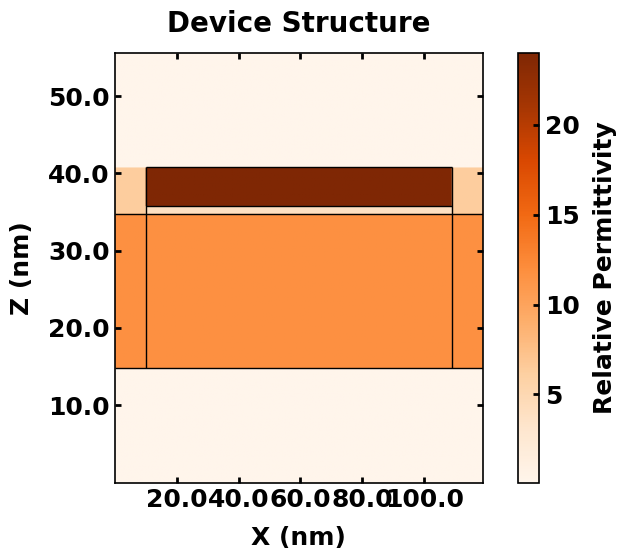

OverflowError: cannot convert float infinity to integer

<Figure size 1000x600 with 2 Axes>

In [ ]:
visualizer = DeviceVisualizer(device_params,aspect_ratio=0.5)
visualizer.visualize_permittivity(cmap='Oranges')
visualizer.plot_electric_potential(figsize=(10,6))
visualizer.plot_electric_field( vector_map = True)
visualizer.plot_carrier_concentration()
visualizer.plot_charge_density()
visualizer.plot_polarization_map()
visualizer.plot_energy_band_diagram()
visualizer.plot_dopant_concentration()
visualizer.plot_current_density_SG(vector_map = True)

## Id-Vg sweep

In [ ]:
V_G_sweep = np.linspace(-0.9, 0.5, 15)
V_D_sweep = 0.05
I_D_sweep, I_S_sweep = simulator.ID_VG(V_D=V_D_sweep, V_G_arr=V_G_sweep)

AttributeError: 'FemDeviceSimulator' object has no attribute 'ID_VG'

In [ ]:
# V_G_sweep2 = np.linspace(-0.9, 0.5, 15)
# V_D_sweep2 = 1.0
# I_D_sweep2, I_S_sweep2 = simulator.ID_VG(V_D=V_D_sweep2, V_G_arr=V_G_sweep2)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

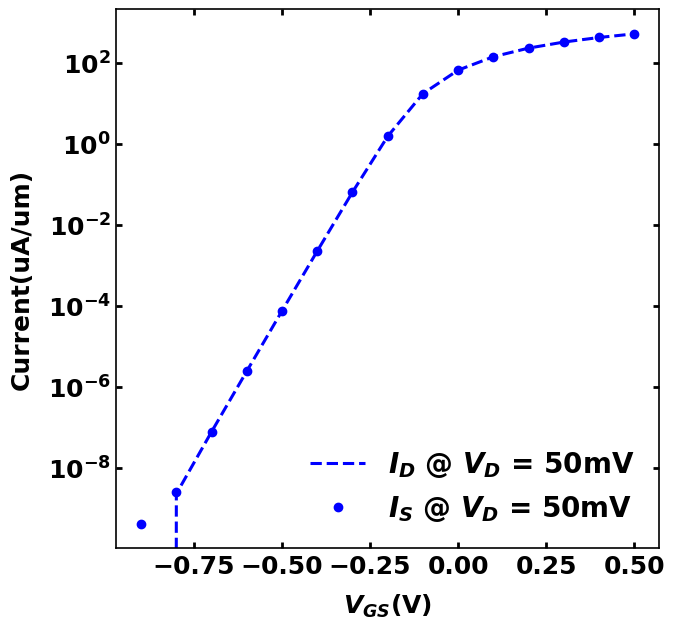

In [ ]:
plt.figure()
plt.plot(V_G_sweep, -I_D_sweep, 'b--', label = '$I_D$ @ $V_D$ = 50mV')
plt.plot(V_G_sweep, -I_S_sweep, 'bo', label = '$I_S$ @ $V_D$ = 50mV')

# plt.plot(V_G_sweep2, -I_D_sweep2, 'r--', label = '$I_D$ @ $V_D$ = 1V')
# plt.plot(V_G_sweep2, -I_S_sweep2, 'ro', label = '$I_S$ @ $V_D$ = 1V')
plt.legend()
plt.ylabel('Current(uA/um)')
plt.xlabel('$V_{GS}$(V)')
plt.yscale('log')
plt.show()

/tmp/ipykernel_632498/2574307241.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(V_G_sweep, np.gradient(V_G_sweep, np.log10(-I_D_sweep)) *1e3, 'b-o', label = '$I_D$ @ $V_D$ = 50mV')
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

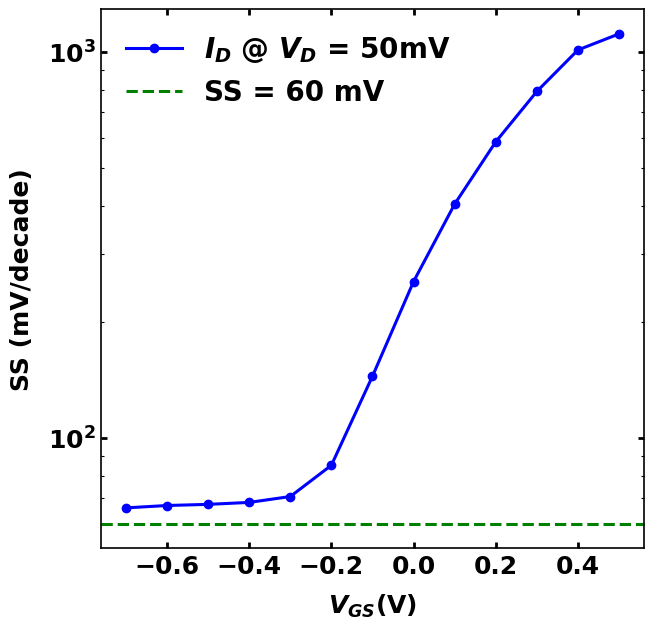

In [ ]:
plt.figure()
plt.plot(V_G_sweep, np.gradient(V_G_sweep, np.log10(-I_D_sweep)) *1e3, 'b-o', label = '$I_D$ @ $V_D$ = 50mV')
# plt.plot(V_G_sweep2, np.gradient(V_G_sweep2, np.log10(-I_D_sweep2)) *1e3, 'r-o', label = '$I_D$ @ $V_D$ = 1.0V')
plt.axhline(60 ,color= 'g', linestyle='--', label = 'SS = 60 mV')

plt.legend()
plt.ylabel('SS (mV/decade)')
plt.xlabel('$V_{GS}$(V)')
plt.yscale('log')
plt.show()

findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

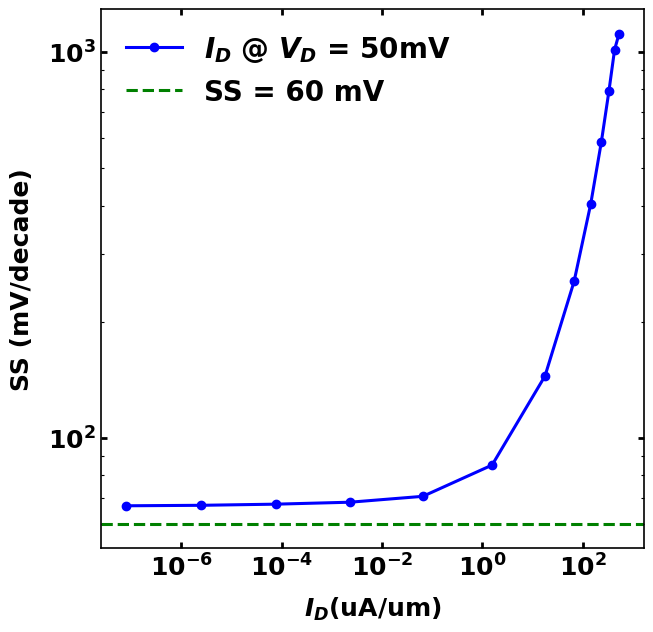

In [ ]:
plt.figure()
filtered_idx = -I_D_sweep>1e-8
plt.plot(-I_D_sweep[filtered_idx], np.gradient(V_G_sweep[filtered_idx], np.log10(-I_D_sweep[filtered_idx])) *1e3, 'b-o', label = '$I_D$ @ $V_D$ = 50mV')

# filtered_idx2 = -I_D_sweep2>1e-8
# plt.plot(-I_D_sweep2[filtered_idx2], np.gradient(V_G_sweep2[filtered_idx2], np.log10(-I_D_sweep2[filtered_idx2])) *1e3, 'r-o', label = '$I_D$ @ $V_D$ = 1.0V')

plt.axhline(60 ,color= 'g', linestyle='--', label = 'SS = 60 mV')

plt.legend()
plt.ylabel('SS (mV/decade)')
plt.xlabel('$I_{D}$(uA/um)')
plt.yscale('log')
plt.xscale('log')
plt.show()